In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
# Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [9]:
!pip install kaggle
!kaggle datasets download -d crawford/cat-dataset
!unzip cat-dataset.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/cats/CAT_05/00001130_020.jpg.cat  
  inflating: ./data/cats/CAT_05/00001130_023.jpg  
  inflating: ./data/cats/CAT_05/00001130_023.jpg.cat  
  inflating: ./data/cats/CAT_05/00001130_026.jpg  
  inflating: ./data/cats/CAT_05/00001130_026.jpg.cat  
  inflating: ./data/cats/CAT_05/00001131_003.jpg  
  inflating: ./data/cats/CAT_05/00001131_003.jpg.cat  
  inflating: ./data/cats/CAT_05/00001131_026.jpg  
  inflating: ./data/cats/CAT_05/00001131_026.jpg.cat  
  inflating: ./data/cats/CAT_05/00001132_007.jpg  
  inflating: ./data/cats/CAT_05/00001132_007.jpg.cat  
  inflating: ./data/cats/CAT_05/00001132_008.jpg  
  inflating: ./data/cats/CAT_05/00001132_008.jpg.cat  
  inflating: ./data/cats/CAT_05/00001132_014.jpg  
  inflating: ./data/cats/CAT_05/00001132_014.jpg.cat  
  inflating: ./data/cats/CAT_05/00001132_017.jpg  
  inflating: ./data/cats/CAT_05/00001132_017.jpg.cat  
  inflating: ./data/cats/CAT_05/00001132_018.j

#this CELL

In [10]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CatDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.image_files = []

        # Traverse through all subfolders and collect .jpg files
        for root, _, files in os.walk(data_folder):
            for file in files:
                if file.endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))

        # SWAIB---

        print(len(self.image_files))
        self.image_files =self.image_files[:50000]
        #-------
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        # print(img_name)
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image,0

# Example usage:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
train_dataset = CatDataset(data_folder='/content/data', transform=transform)


19994


In [11]:
# train_dataset[0].shape

In [12]:
# train_dataset = datasets.CIFAR10(root='./data',\
#               train=True, download=True, transform=transform)

In [13]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [14]:
# train_dataset = datasets.CIFAR10(root='./data',\
#               train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)


In [15]:
for i in dataloader:
  for j in i:
    print(j.shape)
    break
  break

torch.Size([32, 3, 32, 32])


In [16]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 50


In [17]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img


In [18]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [19]:
# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))


Using device: cuda
Epoch [1/50] Batch 100/625 Discriminator Loss: 0.8454 Generator Loss: 0.7074
Epoch [1/50] Batch 200/625 Discriminator Loss: 0.6951 Generator Loss: 0.8191
Epoch [1/50] Batch 300/625 Discriminator Loss: 0.6413 Generator Loss: 0.9744
Epoch [1/50] Batch 400/625 Discriminator Loss: 0.6976 Generator Loss: 0.8744
Epoch [1/50] Batch 500/625 Discriminator Loss: 0.6893 Generator Loss: 0.7076
Epoch [1/50] Batch 600/625 Discriminator Loss: 0.7076 Generator Loss: 0.7464
Epoch [2/50] Batch 100/625 Discriminator Loss: 0.6376 Generator Loss: 1.1947
Epoch [2/50] Batch 200/625 Discriminator Loss: 0.5092 Generator Loss: 1.3774
Epoch [2/50] Batch 300/625 Discriminator Loss: 0.6897 Generator Loss: 0.9119
Epoch [2/50] Batch 400/625 Discriminator Loss: 0.7335 Generator Loss: 1.0470
Epoch [2/50] Batch 500/625 Discriminator Loss: 0.8223 Generator Loss: 0.8446
Epoch [2/50] Batch 600/625 Discriminator Loss: 0.5762 Generator Loss: 1.0088
Epoch [3/50] Batch 100/625 Discriminator Loss: 0.6347 Gen

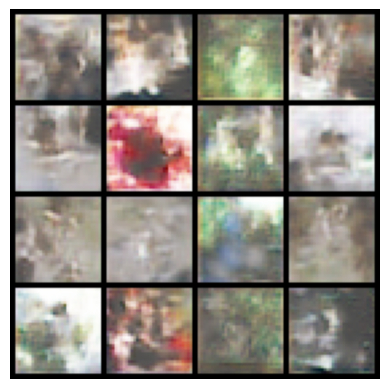

Epoch [11/50] Batch 100/625 Discriminator Loss: 0.6052 Generator Loss: 0.6511
Epoch [11/50] Batch 200/625 Discriminator Loss: 0.4870 Generator Loss: 1.2009
Epoch [11/50] Batch 300/625 Discriminator Loss: 0.6766 Generator Loss: 1.2960
Epoch [11/50] Batch 400/625 Discriminator Loss: 0.5205 Generator Loss: 1.4744
Epoch [11/50] Batch 500/625 Discriminator Loss: 0.4147 Generator Loss: 1.0002
Epoch [11/50] Batch 600/625 Discriminator Loss: 0.5365 Generator Loss: 0.9946
Epoch [12/50] Batch 100/625 Discriminator Loss: 0.4823 Generator Loss: 1.0820
Epoch [12/50] Batch 200/625 Discriminator Loss: 0.6811 Generator Loss: 1.0148
Epoch [12/50] Batch 300/625 Discriminator Loss: 0.6026 Generator Loss: 1.3363
Epoch [12/50] Batch 400/625 Discriminator Loss: 0.6129 Generator Loss: 1.6264
Epoch [12/50] Batch 500/625 Discriminator Loss: 0.7073 Generator Loss: 0.9903
Epoch [12/50] Batch 600/625 Discriminator Loss: 0.6005 Generator Loss: 1.0275
Epoch [13/50] Batch 100/625 Discriminator Loss: 0.7208 Generator

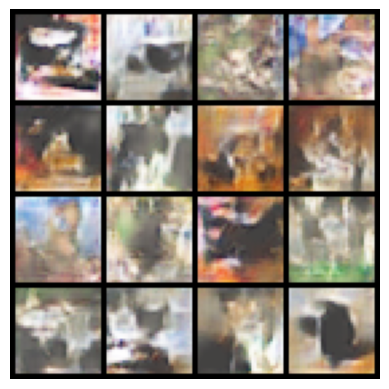

Epoch [21/50] Batch 100/625 Discriminator Loss: 0.5362 Generator Loss: 1.1434
Epoch [21/50] Batch 200/625 Discriminator Loss: 0.7478 Generator Loss: 0.6726
Epoch [21/50] Batch 300/625 Discriminator Loss: 0.4595 Generator Loss: 1.3920
Epoch [21/50] Batch 400/625 Discriminator Loss: 0.5423 Generator Loss: 1.0358
Epoch [21/50] Batch 500/625 Discriminator Loss: 0.5905 Generator Loss: 1.0369
Epoch [21/50] Batch 600/625 Discriminator Loss: 0.9297 Generator Loss: 0.7765
Epoch [22/50] Batch 100/625 Discriminator Loss: 0.5021 Generator Loss: 0.7980
Epoch [22/50] Batch 200/625 Discriminator Loss: 0.4407 Generator Loss: 1.6598
Epoch [22/50] Batch 300/625 Discriminator Loss: 0.5296 Generator Loss: 1.0194
Epoch [22/50] Batch 400/625 Discriminator Loss: 0.7207 Generator Loss: 1.2065
Epoch [22/50] Batch 500/625 Discriminator Loss: 0.8079 Generator Loss: 1.3922
Epoch [22/50] Batch 600/625 Discriminator Loss: 0.6579 Generator Loss: 0.6404
Epoch [23/50] Batch 100/625 Discriminator Loss: 0.5663 Generator

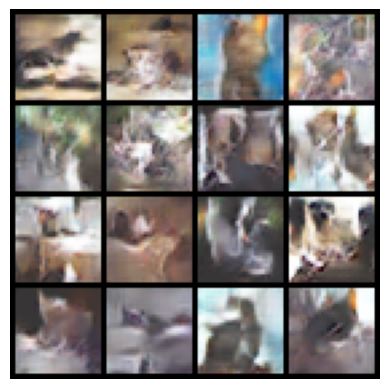

Epoch [31/50] Batch 100/625 Discriminator Loss: 0.8265 Generator Loss: 0.6383
Epoch [31/50] Batch 200/625 Discriminator Loss: 0.6223 Generator Loss: 1.0247
Epoch [31/50] Batch 300/625 Discriminator Loss: 0.3682 Generator Loss: 1.3804
Epoch [31/50] Batch 400/625 Discriminator Loss: 0.6432 Generator Loss: 1.6097
Epoch [31/50] Batch 500/625 Discriminator Loss: 0.4973 Generator Loss: 1.3297
Epoch [31/50] Batch 600/625 Discriminator Loss: 0.5046 Generator Loss: 1.3218
Epoch [32/50] Batch 100/625 Discriminator Loss: 0.5292 Generator Loss: 2.0256
Epoch [32/50] Batch 200/625 Discriminator Loss: 0.5035 Generator Loss: 1.2280
Epoch [32/50] Batch 300/625 Discriminator Loss: 0.5171 Generator Loss: 1.0636
Epoch [32/50] Batch 400/625 Discriminator Loss: 0.4031 Generator Loss: 1.0260
Epoch [32/50] Batch 500/625 Discriminator Loss: 0.5113 Generator Loss: 1.1878
Epoch [32/50] Batch 600/625 Discriminator Loss: 0.6774 Generator Loss: 1.0392
Epoch [33/50] Batch 100/625 Discriminator Loss: 0.3834 Generator

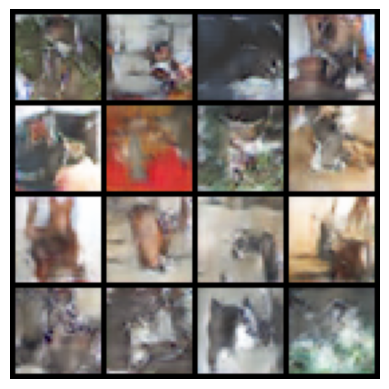

Epoch [41/50] Batch 100/625 Discriminator Loss: 0.5363 Generator Loss: 0.9042
Epoch [41/50] Batch 200/625 Discriminator Loss: 0.4172 Generator Loss: 1.8028
Epoch [41/50] Batch 300/625 Discriminator Loss: 0.8267 Generator Loss: 1.0602
Epoch [41/50] Batch 400/625 Discriminator Loss: 0.6352 Generator Loss: 1.3098
Epoch [41/50] Batch 500/625 Discriminator Loss: 0.5397 Generator Loss: 1.5368
Epoch [41/50] Batch 600/625 Discriminator Loss: 0.8467 Generator Loss: 1.0057
Epoch [42/50] Batch 100/625 Discriminator Loss: 0.7452 Generator Loss: 0.8818
Epoch [42/50] Batch 200/625 Discriminator Loss: 0.6768 Generator Loss: 1.2267
Epoch [42/50] Batch 300/625 Discriminator Loss: 0.4414 Generator Loss: 1.0118
Epoch [42/50] Batch 400/625 Discriminator Loss: 0.6740 Generator Loss: 1.4092
Epoch [42/50] Batch 500/625 Discriminator Loss: 0.5845 Generator Loss: 1.4009
Epoch [42/50] Batch 600/625 Discriminator Loss: 0.5340 Generator Loss: 1.2425
Epoch [43/50] Batch 100/625 Discriminator Loss: 0.3747 Generator

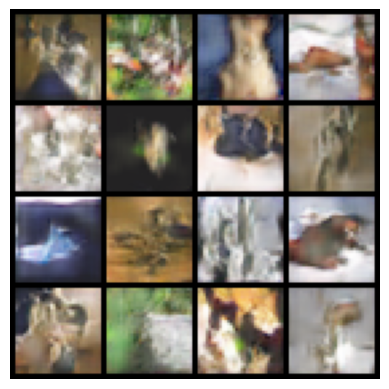

In [20]:
import torch

# Ensure you're using a GPU (like T4) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming `generator` and `discriminator` are already defined
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        # Convert list to tensor and move to GPU
        real_images = batch[0].to(device)

        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)

        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability to classify real and fake images
        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_images = generator(z)

        # Adversarial loss
        g_loss = adversarial_loss(discriminator(gen_images), valid)

        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Progress Monitoring
        # ---------------------
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )

    # Save generated images for every epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()


In [22]:
# Save the generator and discriminator models' state dictionaries
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
